# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 0
#! source activate tensorflow

# 1) Libraries

In [47]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

# 2) Import

In [3]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

path_data = os.path.join(ROOTPATH, 'Data')
path_train = os.path.join(path_data, 'train_set')
path_test = os.path.join(path_data, 'test_set')
path_validation = os.path.join(path_data, 'validation_set')

## Import the list of tickers

In [4]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

## Importing functions

In [5]:
def get_data(path):
    list_dataframes=[]
    allFiles = glob.glob(path + "/csv" + "*.csv")
    i = 0
    list_tickers = []
    
    if computer == 0:
        for file_ in allFiles:
            with open(file_, 'r') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i+=1

    if computer == 1:
        for file_ in allFiles:
            with open(file_, 'r', encoding ='mac_roman') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i += 1
    
    num_files = i
    
    return num_files, list_dataframes, list_tickers


In [6]:
def normalize_data(num_files, list_dataframes, list_tickers):
    
    maxi = 0
    length = 0
    compt = 0
    j = 0
    
    for df in list_dataframes:
        if len(df) > maxi:
            maxi = len(df['Adj Close'])
    
    data = np.array([np.zeros(maxi)]*(num_files))
    data_normalized = np.array([np.zeros(maxi)]*(num_files))
    
    i = 0
    
    for df in list_dataframes:
        arr = np.array(df['Adj Close'])
        if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): 
            data[j] = arr
            minimum = np.min(arr)
            maximum = np.max(arr)
            arr = (arr - minimum) / (maximum - minimum)
            data_normalized[j] = arr
            j += 1
        else:
            list_tickers.pop(i)
            compt += 1
            i-=1
        i += 1
    
    return data_normalized[:-compt], data[:-compt], list_tickers

## Create training, validation and testing set

In [7]:
train_setDf = get_data(path_train)

validation_setDf = get_data(path_validation)

test_setDf = get_data(path_test)

In [8]:
train_setData_n, train_setData, list_tickers_train = normalize_data(train_setDf[0], train_setDf[1], train_setDf[2])

validation_setData_n, validation_setData, list_tickers_val = normalize_data(validation_setDf[0], validation_setDf[1], validation_setDf[2])

test_setData_n, test_setData, list_tickers_test = normalize_data(test_setDf[0], test_setDf[1], test_setDf[2])

print("train_setData is of length : ",len(train_setData))
print("test_setData is of length : ",len(test_setData))
print("validation_setData is of length : ",len(validation_setData))

train_setData is of length :  114
test_setData is of length :  28
validation_setData is of length :  27


# 3) Functions

## Initializing functions

In [9]:
def weight_variable(num_input, num_output):
    weight_init = tf.random_normal_initializer(stddev=1.0/np.sqrt(num_input))
    weight_shape = [num_input, num_output]
    W = tf.get_variable('W', weight_shape, initializer = weight_init)
    return(W)

def bias_variable(num_output):
    bias_init = tf.constant_initializer(value = 0)
    bias_shape = [num_output]
    b = tf.get_variable('b', bias_shape, initializer = bias_init)
    return(b)

## Fetch data functions

In [10]:
def find_ticker_batch(batch, data_norm, list_tickers):
    true = batch
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][100] - true[100] == 0:
            index = i
        i += 1
    ticker = list_tickers[index]
    return(ticker, index)

## Tensorboard functions

In [11]:
def variable_summary_light(var):
    with tf.variable_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

In [12]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [13]:
def create_summaries(loss, x, latent, output):
    writer = tf.summary.FileWriter("./logs")
    tf.summary.scalar("Loss", loss)
    layer_grid_summary("Input", x, [28, 28])
    layer_grid_summary("Encoder", latent, [2, 1])
    layer_grid_summary("Output", output, [28, 28])
    return writer, tf.summary.merge_all()

## Training functions

In [14]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [15]:
def layer_batch_normalization(x, n_out, phase_train):

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

## Building functions

In [49]:
def layer(input_tensor, num_input, num_output, phase_train, layer_name, bool_drop):
    with tf.variable_scope(layer_name):
        with tf.variable_scope('weights'):
            W = weight_variable(num_input, num_output)
            variable_summary_light(W)
    
        with tf.variable_scope('biases'):
            b = bias_variable(num_output)
            variable_summary_light(W)
            
        
        if bool_drop:
            dropped_or_not = dropout(input_tensor, keep_prob)
        else:
            dropped_or_not = input_tensor
            
        logits = tf.matmul(dropped_or_not, W) + b
            
    return tf.nn.relu(layer_batch_normalization(logits, num_output, phase_train)), W

In [50]:
def encoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("encode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_e_1 = layer(input_tensor, num_input, num_encode_1, phase_train, "encoder", False)
            
        with tf.variable_scope('output'):
            output, W_e_2 = layer(h_1, num_encode_1, n_code, phase_train, "encoder",True)
            
    return output, W_e_2

def decoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_d_1 = layer(input_tensor, n_code, num_decode_1, phase_train, "encoder",True)
        
        with tf.variable_scope('output'):
            output, W_d_2 = layer(h_1, num_decode_1, num_output, phase_train, "decoder",False)
            
    return output, W_d_2


In [51]:
def dropout(encoder_op, keep_prob):
    with tf.variable_scope("dropped"):
        dropped = tf.nn.dropout(encoder_op, keep_prob)
    return dropped

In [52]:
def mse(output, x):
    with tf.variable_scope('mse'):
        mse = tf.squared_difference(output, x)
    return mse

In [53]:
def regularizer(W_e, W_d):
    with tf.variable_scope("regularizer"):
        regularizer = tf.nn.l2_loss(W_e) + tf.nn.l2_loss(W_d)
    return regularizer

In [54]:
def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

In [55]:
def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

In [56]:
def evaluate(output, x):
    with tf.variable_scope('validation'):
        
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        
        val_loss = tf.reduce_mean(l2_norm)
        
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        
        return val_loss, val_summary_op

# 4) Training

## Parameters

In [131]:
# Training Parameters
learning_rate = 0.00001
num_steps = 7000
batch_size = 10
lambd = 0.3
val_dropout = 0.7

display_step = 100

# Network Parameters 

num_input = 503 # 503 days considered
num_encode_1 = 250 # 1st layer of encode
n_code = 5  # bottleneck layer
num_decode_1 = 250 # 1st layer of decode
num_output = num_input


date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

## Run the training

Step 1: Minibatch Loss: 38.272598
Estimated remaining time =  1669.1538627147675 s

Step 100: Minibatch Loss: 29.251457
Estimated remaining time =  536.5888631343842 s

Step 200: Minibatch Loss: 22.278299
Estimated remaining time =  541.4224128723145 s

Step 300: Minibatch Loss: 16.842213
Estimated remaining time =  559.5496769746145 s

Step 400: Minibatch Loss: 12.588860
Estimated remaining time =  557.6291298866272 s

Step 500: Minibatch Loss: 9.297906
Estimated remaining time =  537.2995638847351 s

Step 600: Minibatch Loss: 6.778734
Estimated remaining time =  525.0438995361328 s

Step 700: Minibatch Loss: 4.860403
Estimated remaining time =  515.3203082084656 s

Step 800: Minibatch Loss: 3.445852
Estimated remaining time =  501.22787380218506 s

Step 900: Minibatch Loss: 2.414156
Estimated remaining time =  493.26003079944184 s

Step 1000: Minibatch Loss: 1.673218
Estimated remaining time =  487.6901021003723 s

Step 1100: Minibatch Loss: 1.111208
Estimated remaining time =  480.6

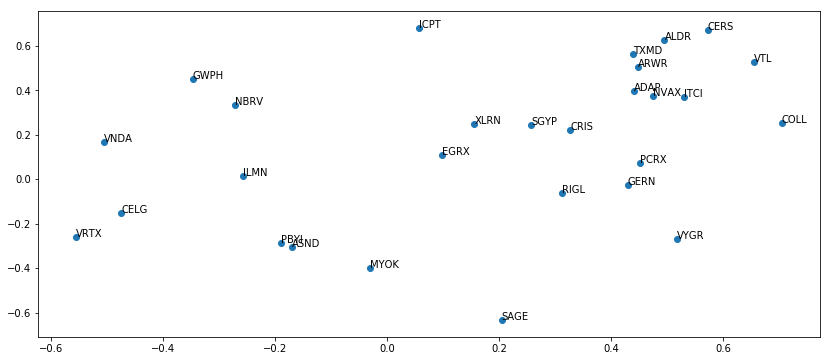

In [132]:
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        
        # Placeholders
        x = tf.placeholder("float", [None, num_input])
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout
        
        # Extract the latent information (logits from the bottleneck layer)
        code, W_e = encoder(x, n_code, phase_train)
        
        # Extract the outputs of the autoencoder
        output, W_d = decoder(code, n_code, phase_train)
        
        cost = loss(mse(output,x), regularizer(W_e, W_d), lambd, num_input, batch_size)
        
        train_op = training(cost, learning_rate)
        
        eval_op, val_summary_op = evaluate(output, x)
        
        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()
        
        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        
        
        # Create the session that will be runned for training
        sess = tf.Session()
        
        # Initialize a summary for our variables during the training
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        # Time to launch the session
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        start_time = time()
        
        for i in range(1, num_steps+1):
            
            # Prepare Data
            total_batch = int(len(train_setData_n)/batch_size)

            for j in range(total_batch):
                mini_batch_x, _ = next_batch(batch_size, train_setData_n, train_setData_n)

                _, l, summary = sess.run([train_op, cost, summary_op], 
                            feed_dict={x: mini_batch_x, phase_train: True, keep_prob: val_dropout})

            # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
            summary_writer.add_summary(summary, i)
                
            if i % display_step == 0 or i == 1:
                
                print('Step %i: Minibatch Loss: %f' % (i, l))
                curr_time = time()
                elapsed_time = curr_time-start_time
                print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')
                
                # Save the model during the training at save_path
                #save_path = saver.save(sess, logs_path)
                #print("Model saved in file: %s" % save_path)
                    
#                 print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

#                 train_writer.add_summary(train_summary, sess.run(global_step))

#                 validation_loss, in_image, out_image, val_summary = sess.run([eval_op, val_summary_op], feed_dict={x: validation_setData, phase_train: False})

#                 val_writer.add_summary(in_image, sess.run(global_step))
#                 val_writer.add_summary(out_image, sess.run(global_step))
#                 val_writer.add_summary(val_summary, sess.run(global_step))

#                 print("Validation Loss:", validation_loss)

#                 save_path = saver.save(sess, model_path)
#                 print("Model saved in file: %s" % save_path)

#                 curr_time = time()
#                 elapsed_time = curr_time-start_time
#                 print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')
   
    
### Here we plot the latent space (n_code dimension)
        ae_codes, test_loss = sess.run([code, cost], 
                            feed_dict={x: test_setData_n, phase_train: False, keep_prob:1})
        fig, ax = plt.subplots()
        ax.scatter(ae_codes[:,0], ae_codes[:,1])
        for i, txt in enumerate(list_tickers_test):
            ax.annotate(txt, (ae_codes[i,0], ae_codes[i,1]))
        
        batch_x, _ = next_batch(batch_size,test_setData_n,test_setData_n)
        l , p = sess.run([cost, output] , feed_dict={x: batch_x, phase_train: False, keep_prob: 1})
        print('Minibatch Loss: ', l) 
       

# 8) Exporting

In [133]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519340346/
Then open http://0.0.0.0:6006/ into your web browser


Or Run the command line:
--> python -m tensorboard.main --logdir=C:\tmp\tensorflow_logs\autoencoder1\1519340346\
Then open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type




In [134]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519250108/

# 9) Plotting

In [143]:
#V2
def denormalize(p,batch, dataset_norm, dataset, list_tickers):
    batch_size = len(batch)
    unnormalized_p = {}
    for j in range(batch_size):
        (ticker, index) = find_ticker_batch(batch[j], dataset_norm, list_tickers)

        minimum = np.min(dataset[index])
        maximum = np.max(dataset[index])
        pred = p[j] * (maximum - minimum) + minimum
        unnormalized_p[index] = (ticker, pred)
        
    return unnormalized_p
    
unnormalized_p = denormalize(p, batch_x, test_setData_n, test_setData, list_tickers_test)

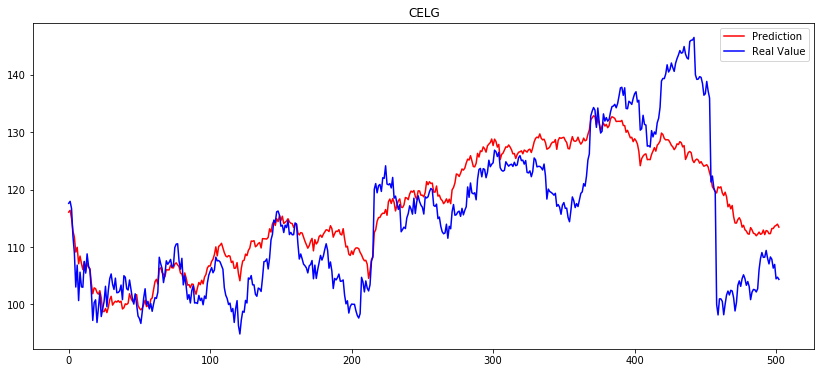

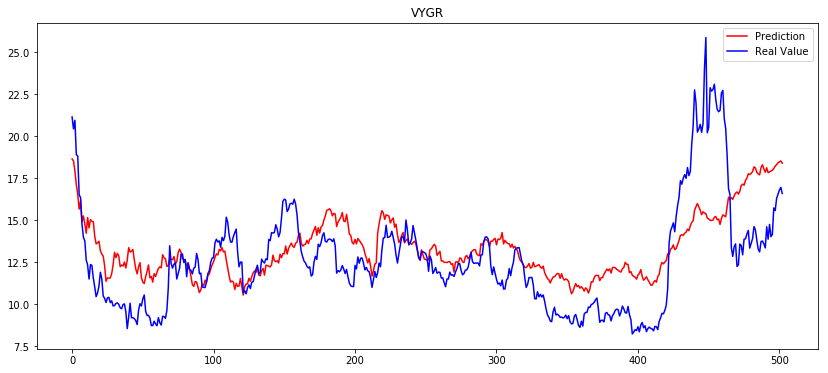

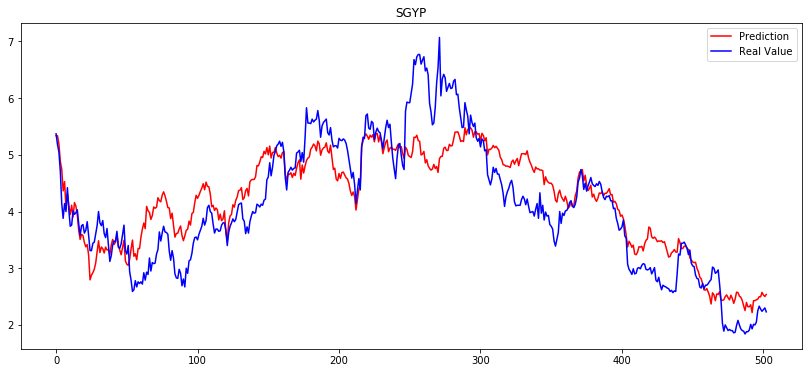

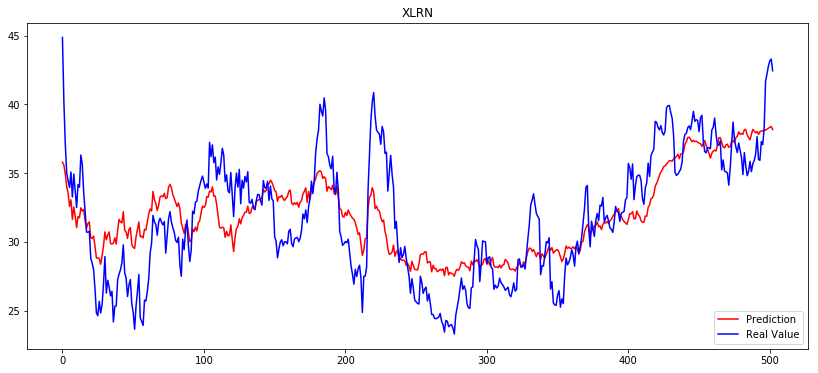

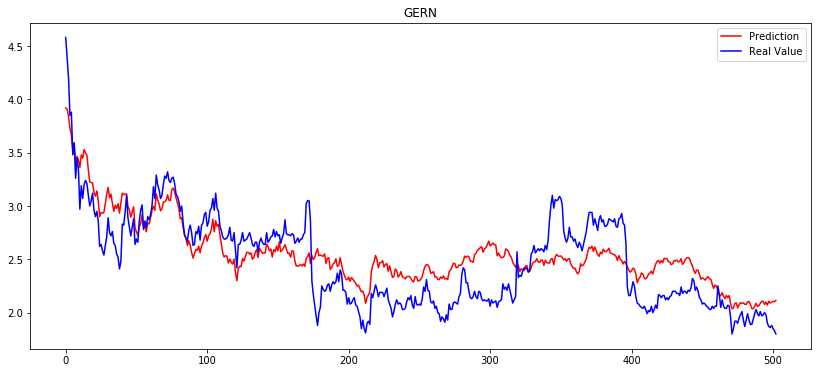

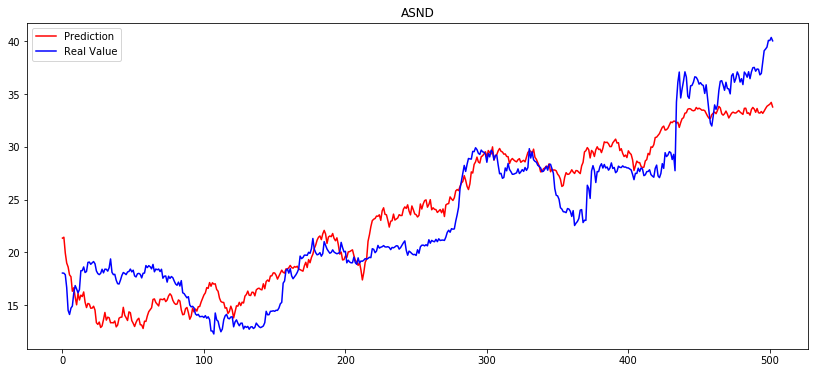

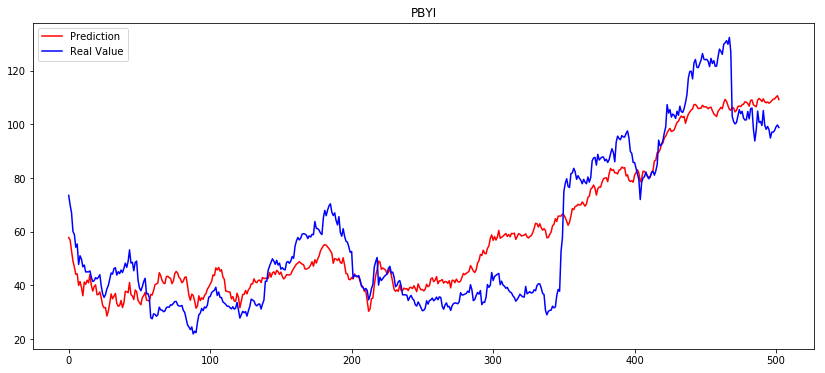

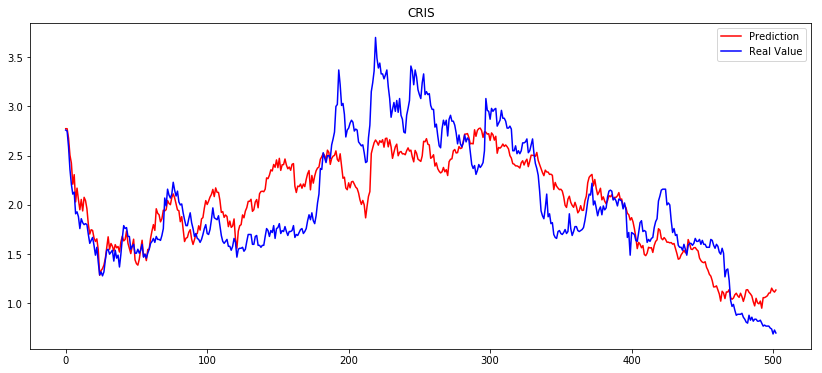

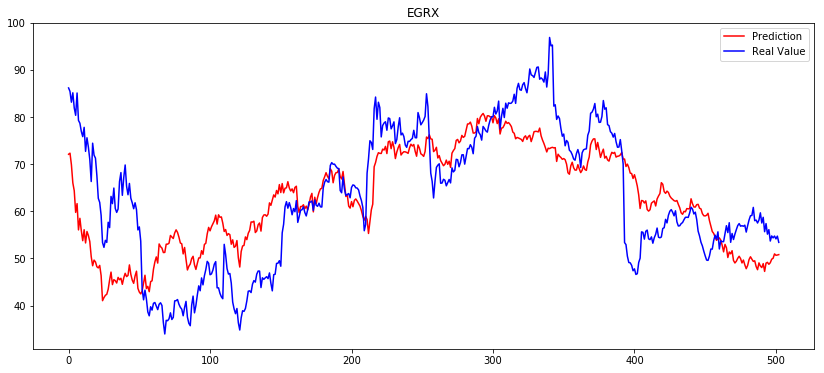

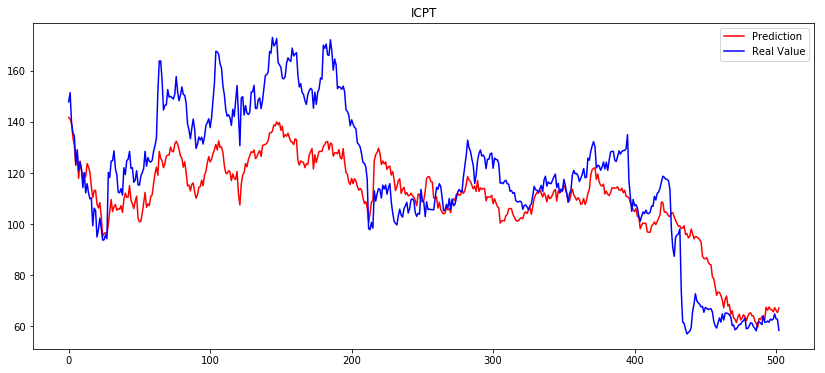

In [144]:
for j in unnormalized_p.keys():
    plt.figure()
    plt.plot(unnormalized_p[j][1] ,'r', label = "Prediction")
    plt.hold
    plt.plot(test_setData[j] ,'b',label = "Real Value")
    plt.title(unnormalized_p[j][0])
    plt.legend()
    plt.show;

# Re checking

In [145]:
diff = abs(p - batch_x)
L2 = np.sqrt(np.multiply(diff,diff))

In [146]:
for i in L2:
    print(i)

[2.96116902e-02 3.03152617e-02 3.37369763e-02 1.74734712e-02
 5.31478187e-02 1.17951197e-01 6.00882242e-02 1.24188583e-01
 5.43218351e-02 7.90674569e-02 5.94960007e-02 1.00776259e-03
 6.05027983e-03 3.10402845e-02 4.14996804e-03 5.01981585e-03
 2.61800167e-02 8.99857892e-02 4.96087551e-02 3.74688298e-02
 1.01062349e-01 4.42641907e-02 8.82249411e-03 6.28674094e-02
 7.56224815e-03 3.40243475e-02 7.49633284e-02 1.96875718e-02
 5.71211374e-02 7.09446731e-02 7.53880099e-02 7.03440941e-02
 4.48768273e-02 7.79030974e-02 3.15575442e-02 2.74225121e-02
 3.83369209e-02 5.41895321e-02 3.13567596e-02 1.08007560e-01
 8.96483848e-02 5.30933615e-02 4.44046553e-02 4.62720568e-02
 3.00240066e-02 8.89075770e-03 6.51699447e-03 5.97755703e-03
 3.32056270e-02 3.56700566e-02 3.46795313e-02 4.57779360e-02
 1.10948515e-02 2.20174161e-02 3.84759109e-02 5.79217498e-03
 1.33563802e-02 4.34466342e-03 1.42158962e-02 4.49422999e-02
 4.86886170e-02 5.38118624e-02 6.44046259e-02 2.77409133e-02
 3.94676138e-02 1.405398

In [147]:
print('average error in our case = ',np.mean(L2))

average error in our case =  0.10132308361798815


In [148]:
random = np.random.uniform(0,1,(10,503))

In [149]:
diff_random = abs(batch_x - random)
L2_random = np.sqrt(np.multiply(diff_random,diff_random))
print('average error in a random case = ',np.mean(L2_random))

average error in a random case =  0.32037923498671167


# Finding the commonals

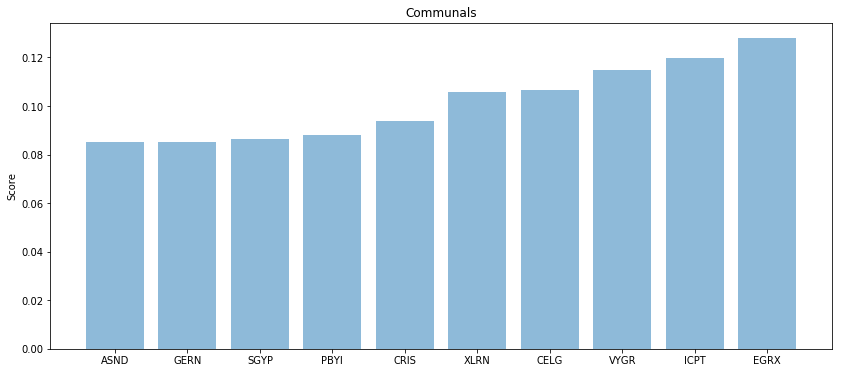

In [150]:



sorted_by_value = []

for i in range(len(p)):
    sorted_by_value.append((np.mean(diff[i]),i))
    
objects =  []
performance = sorted(sorted_by_value)

for i in performance:
    ticker, index = find_ticker_batch(batch_x[i[1]], test_setData_n, list_tickers_test)
    objects.append(ticker)

    
y_pos = np.arange(len(objects))
plotable_performance = [i[0] for i in performance]


plt.bar(y_pos, plotable_performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Communals')
 
plt.show();


